In [17]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")

import random
import time as time
import pandas as pd
import numpy as np

from rmgpy.molecule.group import Group
from rmgpy.data.base import Entry
from rmgpy.data.thermo import ThermoData

from thermo import ThermoGroups
from utils import make_mol
from parameters import Ts

# Load HBI corrections

In [2]:
HBI_correction_df = pd.read_csv("../data/hbi.csv")
HBI_correction_df

,radical_smiles,radical_resonance_smiles,closed_shell_smiles,closed_shell_H298 (kcal/mol),closed_shell_S298 (cal/mol/K),closed_shell_Cp300 (cal/mol/K),closed_shell_Cp400 (cal/mol/K),closed_shell_Cp500 (cal/mol/K),closed_shell_Cp600 (cal/mol/K),closed_shell_Cp800 (cal/mol/K),...,radical_num_resonance,HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),HBI_Cp600 (cal/mol/K),HBI_Cp800 (cal/mol/K),HBI_Cp1000 (cal/mol/K),HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,O=C(O)OC(O)(O)O,-272.617591,98.406448,31.562314,36.827897,41.095602,44.234417,48.821415,...,1,49.103465,-4.589644,2.364565,1.559776,0.412894,-0.172027,-1.041685,-1.683176,-3.705453
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,O=C(O)OC(O)(O)O,-272.617591,98.406448,31.562314,36.827897,41.095602,44.234417,48.821415,...,1,49.194200,-7.808181,0.968866,0.741762,0.402841,0.476043,0.534574,0.412253,-1.394250
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,O=C(O)OC(O)O,-231.363843,94.127419,27.214474,31.965583,36.032333,39.309560,44.059044,...,1,44.040974,-4.610350,1.758768,2.587490,2.714389,2.346110,1.178471,0.282207,-0.997631
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)OO,-234.219312,145.598548,52.706616,62.438776,71.442505,78.070363,87.443365,...,1,48.558735,-12.393484,3.863088,3.589450,2.161239,1.702481,1.262146,-0.928170,-3.176204
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,O=COC(O)(O)O,-216.499044,92.684651,26.935163,30.962696,34.637667,37.592447,42.375430,...,1,36.001481,-4.835845,5.443029,5.881647,4.696512,3.708683,1.768296,0.144000,-3.234417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,C1=C[CH]C=1,[C]1=CC=C1,C1=CC=C1,104.333500,57.818020,15.504000,19.920000,23.474000,26.261000,30.329000,...,2,51.773082,3.435468,-0.850889,-1.431243,-1.911856,-2.405821,-3.006968,-3.449835,-4.556360
2863,C=C=C1C=[C]C1,C=C=C1C=[C]C1,C=C=C1C=CC1,91.366874,50.394958,22.416919,29.489266,35.000461,39.185145,45.162263,...,1,66.366211,25.815240,0.258337,-1.155381,-2.024215,-2.373362,-2.314548,-2.090808,-2.168527
2864,[CH2]C1=CC#CC1,[CH2]C1=CC#CC1,CC1=CC#CC1,131.227000,72.956831,23.409000,30.017000,34.619000,39.828000,46.529000,...,3,32.271344,0.823844,-0.802362,-1.521882,-1.227900,-2.500041,-3.127836,-3.711522,-2.960733
2865,[CH2]C1=CC#CC1,C=C1[CH]C#CC1,C=C1CC#CC1,136.767000,72.435147,22.819000,29.017000,34.189000,38.448000,45.419000,...,3,26.731344,0.773844,-0.212362,-0.521882,-0.797900,-1.120041,-2.017836,-2.931522,-2.570733


In [3]:
mols = HBI_correction_df["radical_smiles"].apply(make_mol)
mols = mols.to_list()

In [4]:
HBI_corrections = HBI_correction_df.apply(lambda x: ThermoData(
    H298=(x["HBI_H298 (kcal/mol)"], "kcal/mol"),
    S298=(x["HBI_Sint298 (cal/mol/K)"], "cal/mol/K"),
    Cpdata=([x[f"HBI_Cp{T} (cal/mol/K)"] for T in Ts], "cal/mol/K"),
    Tdata=(Ts, "K"),
), axis=1)
HBI_corrections = HBI_corrections.to_list()

In [5]:
mols_corrections = list(zip(mols, HBI_corrections))

# Generate tree for plot

In [33]:
n_jobs = 4
random.seed(0)
samples = random.sample(mols_corrections, 4)

In [34]:
#clean tree
tree = ThermoGroups(label="radical",
                    name="Radical Corrections")

tree.entries["Root"] = Entry(
    index = 0,
    label = "Root",
    item = Group().from_adjacency_list(f"""1 * R u[1,2,3,4]"""),
    data = None,
    data_count = 0,
    parent = None,
)
tree.entries["RJ1"] = Entry(
    index = 0,
    label = "RJ1",
    item = Group().from_adjacency_list(f"""1 * R u1"""),
    data = None,
    data_count = 0,
    parent = tree.entries["Root"],
)

tree.entries["Root"].children = [tree.entries["RJ1"]]
tree.top = [tree.entries["Root"]]

min_mols_corrections_to_split = 1

start = time.time()
template_mol_map_exact = tree.generate_tree(mols_corrections=samples, obj=None, Ts=None, nprocs=1, min_splitable_entry_num=2,
                                          min_mols_corrections_to_spawn=20, max_batch_size=np.inf, outlier_fraction=0.02, stratum_num=8,
                                          new_fraction_threshold_to_reopt_node=0.25, extension_iteration_max=2, extension_iteration_item_cap=100, 
                                            min_mols_corrections_to_split=min_mols_corrections_to_split, n_jobs=n_jobs)
end = time.time()
print("Tree generation:")
print(end-start)


tree.check_tree()

start = time.time()
template_mol_map = tree.get_molecule_matches(mols_corrections=samples,
                                                     exact_matches_only=False, n_jobs=n_jobs)

end = time.time()
print("Mol mapping:")
print(end-start)

INFO:root:Getting molecule matches...
[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
INFO:root:4.0
INFO:root:2
INFO:root:3
INFO:root:iteration_max achieved terminating early
INFO:root:5
INFO:root:6
INFO:root:Getting molecule matches...


Tree generation:
0.7418110370635986
Mol mapping:
0.47620081901550293


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Root


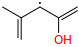

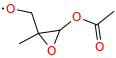

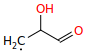

RJ1


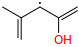

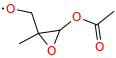

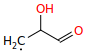

RJ1_Ext-1R-R_Ext-1R-R


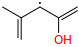

RJ1_1R->C


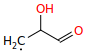

RJ1_N-1R->C


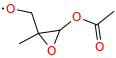

RJ1_Ext-1R-R_Ext-1R-R_Ext-3R!H-R_Ext-2R!H-R


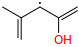

In [40]:
for label in template_mol_map:
    print(label)
    for mol in template_mol_map[label]:
        display(mol[0])

In [41]:
tree.entries["RJ1"].children

[<Entry index=2 label="RJ1_Ext-1R-R_Ext-1R-R">,
 <Entry index=3 label="RJ1_1R->C">,
 <Entry index=4 label="RJ1_N-1R->C">]